In [1]:
#importación de librerías
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import csv
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error

Importación y tratamiento de datos

In [2]:
#Parametros
dia_prediccion = '2025-06-11'
# Crea las marcas de tiempo para el inicio y el final del día
inicio_dia = pd.to_datetime(dia_prediccion + ' 00:00:00+00:00')
fin_dia = pd.to_datetime(dia_prediccion + ' 23:59:59+00:00')
departamento = 'HUILA'
municipio = 'PITALITO'
#Carga de los archivos csv por año ubicados en: https://drive.google.com/drive/folders/10BtFS1WbWR7ZQ19MlgSB74CF0we8ztUB?usp=drive_link 
#df_2020 = pd.read_csv('D:/DevHitss/unir/Maestria/TFM/humedad_5a/TFM.humedad_2020.csv')
#df_2021 = pd.read_csv('D:/DevHitss/unir/Maestria/TFM/humedad_5a/TFM.humedad_2021.csv')
#df_2022 = pd.read_csv('D:/DevHitss/unir/Maestria/TFM/humedad_5a/TFM.humedad_2022.csv')
df_2023 = pd.read_csv('D:/DevHitss/unir/Maestria/TFM/humedad_5a/TFM.humedad_2023.csv')
df_2024 = pd.read_csv('D:/DevHitss/unir/Maestria/TFM/humedad_5a/TFM.humedad_2024.csv')
df_2025 = pd.read_csv('D:/DevHitss/unir/Maestria/TFM/humedad_5a/TFM.humedad_2025.csv')
df_2025_2 = pd.read_csv('D:/DevHitss/unir/Maestria/TFM/humedad_5a/TFM.humedad_2025_may_jun.csv')
#Concatenación de los 6 archivos en un solo dataframe llamado df_concat
#df_concat = pd.concat([df_2020, df_2021, df_2022, df_2023, df_2024, df_2025, df_2025_2], axis=0, ignore_index=True)
df_concat = pd.concat([df_2023, df_2024, df_2025, df_2025_2], axis=0, ignore_index=True)
df_concat = df_concat.drop('_id', axis=1)
#Asegurarnos que la fechamedida sea un tipo de dato datetime
df_concat['fechamedida'] = pd.to_datetime(df_concat['fechamedida'])
#Creación de columnas para posterior análisis
df_concat['anio'] = df_concat['fechamedida'].dt.year
df_concat['mes'] = df_concat['fechamedida'].dt.month
df_concat['dia'] = df_concat['fechamedida'].dt.day
df_concat['hora'] = df_concat['fechamedida'].dt.hour
df_concat['nombre_mes'] = df_concat['mes'].map({
     1: 'Enero', 2: 'Febrero', 3: 'Marzo', 4: 'Abril', 5: 'Mayo', 6: 'Junio'
     , 7: 'Julio', 8: 'Agosto', 9: 'Septiembre', 10: 'Octubre', 11: 'Noviembre', 12: 'Diciembre'
})

Creación de dataframes para entregarlos al modelo

In [3]:
#Creamos un nuevo dataframe con valores que no contengan cero (0) en el valor observado
df_filtrado = df_concat[df_concat['valorobservado'] != 0]
#comprobación de registros cargados desde los archivos dispuestos
print(len(df_filtrado))
df_exportar = df_filtrado.head(1000)
# Filtrar los datos por departamento y municipio
df_municipio = df_filtrado[(df_filtrado['departamento'] == departamento) & (df_filtrado['municipio'] == municipio)]
print(len(df_municipio))
df_real = df_municipio[(df_municipio['fechamedida'] >= inicio_dia) & (df_municipio['fechamedida'] <= fin_dia)]
df_municipio = df_municipio[df_municipio['fechamedida'] < inicio_dia]
#df_municipio.to_csv (f"df_municipio.csv", sep='|', header= True, encoding='utf-8', index=False)

14284748
7015


In [4]:
#Activar las siguientes líneas si desea revisar información
#df_municipio.describe()
#df_municipio.head(10)
#df_municipio.dtypes

INICIO DEL MODELO

In [5]:
# Convertir la columna de fecha y ordenar
df_municipio.set_index('fechamedida', inplace=True)
serie_municipio = df_municipio['valorobservado'].astype(float).resample('h').mean()
#creación de los datos de entrenamiento
serie_train = serie_municipio[serie_municipio.index < inicio_dia]
forecast_index = pd.date_range(start=inicio_dia, end=fin_dia, freq="h")
# Entrenar modelo SARIMA (p,d,q)(P,D,Q,24) - estacionalidad diaria
modelo = SARIMAX(serie_train, order=(1,1,1), seasonal_order=(1,1,1,24), enforce_stationarity=False, enforce_invertibility=False)
modelo_entrenado = modelo.fit()
predicciones = modelo_entrenado.get_forecast(steps=24)
predicciones_df = predicciones.predicted_mean
predicciones_df.index = forecast_index

Gráfica del la predicción del modelo

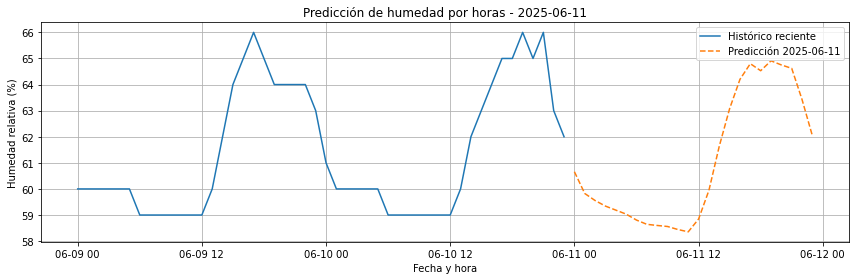

In [6]:
# Mostrar resultados
plt.figure(figsize=(12, 4))
plt.plot(serie_municipio[-48:], label="Histórico reciente")
plt.plot(predicciones_df, label="Predicción " + dia_prediccion, linestyle='--')
plt.legend()
plt.title("Predicción de humedad por horas - " + dia_prediccion)
plt.xlabel("Fecha y hora")
plt.ylabel("Humedad relativa (%)")
plt.grid(True)
plt.tight_layout()
plt.show()


Alistamiento de información para graficar los resultados

In [7]:
#Se realiza alistamiento del df con los valores predichos de la humedad relativa
predicciones_df = predicciones_df.reset_index()
predicciones_df.columns = ['Hora', 'humedad_predicha']
predicciones_df['Hora'] = pd.to_datetime(predicciones_df['Hora'])
predicciones_df['Hora'] = predicciones_df['Hora'].dt.tz_localize(None)
#print(predicciones_df)
#Se realiza alistamiento del df con los valores reales de la humedad relativa (ejercicio de comparación)
df_real_agrupado = df_real.groupby('fechamedida')['valorobservado'].mean().reset_index()
df_real_agrupado['fechamedida'] = pd.to_datetime(df_real_agrupado['fechamedida'])
df_real_agrupado['fechamedida'] = df_real_agrupado['fechamedida'].dt.tz_localize(None)
df_real_agrupado.rename(columns={'fechamedida': 'Hora'}, inplace=True)
#print(df_real_agrupado)
df_final = pd.merge(predicciones_df, df_real_agrupado, on='Hora', how='outer')
# Ordenar por tiempo para asegurar que la gráfica se vea bien
df_final.sort_values('Hora', inplace=True)

In [8]:
#activar si se requiere verificar el tipo de dato
#print(predicciones_df['Hora'].dtype)
#print(df_real_agrupado['Hora'].dtype)

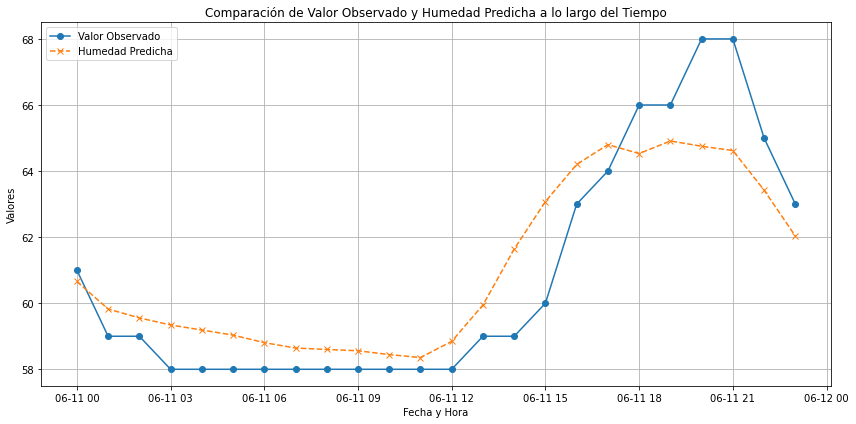

In [9]:
# Creación gráfica de las predicciones por hora y el valor real
plt.figure(figsize=(12, 6))
# Graficar 'valor_observado'
plt.plot(df_final['Hora'], df_final['valorobservado'], label='Valor Observado', marker='o', linestyle='-')
# Graficar 'humedad_predicha'
plt.plot(df_final['Hora'], df_final['humedad_predicha'], label='Humedad Predicha', marker='x', linestyle='--')
# Añadir títulos y etiquetas
plt.title('Comparación de Valor Observado y Humedad Predicha a lo largo del Tiempo')
plt.xlabel('Fecha y Hora')
plt.ylabel('Valores')
plt.grid(True)
plt.legend() # Mostrar la leyenda para identificar cada línea
plt.tight_layout() # Ajustar el diseño para que no se corten las etiquetas
plt.show()

Evaluacion del modelo

In [10]:
# Evaluar el rendimiento del modelo
mae = mean_absolute_error(df_real["valorobservado"].values, predicciones_df['humedad_predicha'].values)
# Calcular el MSE y el RMSE
mse = mean_squared_error(df_real["valorobservado"].values, predicciones_df['humedad_predicha'].values)
rmse = np.sqrt(mse)
print(f"MAE del modelo de regresión: {mae:.2f}")
print(f"RMSE del modelo de regresión: {rmse:.2f}")

MAE del modelo de regresión: 1.25
RMSE del modelo de regresión: 1.53


In [11]:
print(df_final)

                  Hora  humedad_predicha  valorobservado
0  2025-06-11 00:00:00         60.658614            61.0
1  2025-06-11 01:00:00         59.825030            59.0
2  2025-06-11 02:00:00         59.555147            59.0
3  2025-06-11 03:00:00         59.341735            58.0
4  2025-06-11 04:00:00         59.187917            58.0
5  2025-06-11 05:00:00         59.034417            58.0
6  2025-06-11 06:00:00         58.806059            58.0
7  2025-06-11 07:00:00         58.643243            58.0
8  2025-06-11 08:00:00         58.599588            58.0
9  2025-06-11 09:00:00         58.560358            58.0
10 2025-06-11 10:00:00         58.444586            58.0
11 2025-06-11 11:00:00         58.355726            58.0
12 2025-06-11 12:00:00         58.845934            58.0
13 2025-06-11 13:00:00         59.946209            59.0
14 2025-06-11 14:00:00         61.638917            59.0
15 2025-06-11 15:00:00         63.077407            60.0
16 2025-06-11 16:00:00         